# Exploratory Data Analysis

In the [PetFinder Competition](https://www.kaggle.com/c/petfinder-pawpularity-score/overview), the task is to predict engagement with a pet's profile based on the photograph for that profile. Accompanying every photo are hand-labelled metadata describing some aspects of the photo. The dataset for this competition therefore comprises both images and tabular data. This notebook analyzes the photo data and metadata and then tries to explain what some deep neural networks are learning using modern tools.

## Photo Metadata Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
FOLDERNAME = 'Colab Notebooks/pawpularity'

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

%cd /content/drive/MyDrive/$FOLDERNAME
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/pawpularity
 checkpoints/    models/                'Quick Train2.ipynb'
 data/           Pawpularity_EDA.ipynb   saliency.pdf
 grad_cams.pdf   paw_size.pdf           'SWIN Test.ipynb'


In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as T
from PIL import Image

In [ ]:
paw_df = pd.read_csv('data/train.csv', index_col = 0)
paw_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
Id,,,,,,,,,,,,,
0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


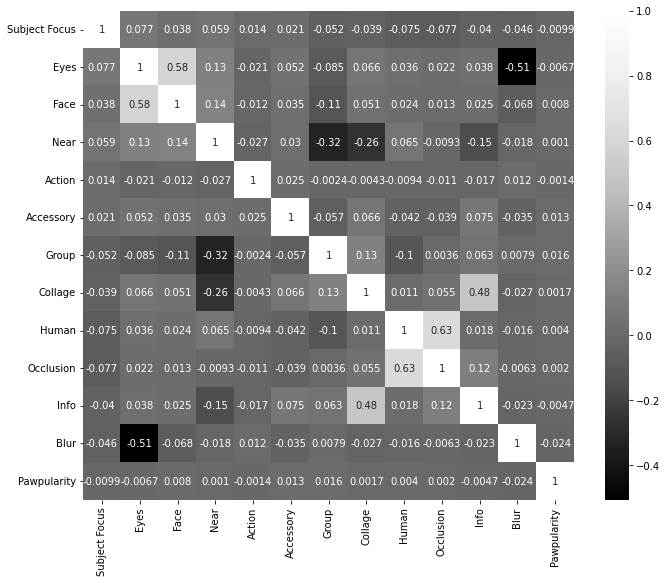

In [ ]:
heatmap_df = pd.read_csv('data/train.csv').drop(columns = 'Id')
heatmap_df['Pawpularity'] = heatmap_df['Pawpularity']/100
heatmap_df = heatmap_df.corr()
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(heatmap_df, cmap = 'Greys_r', annot = True)
# plt.savefig('coor.pdf')

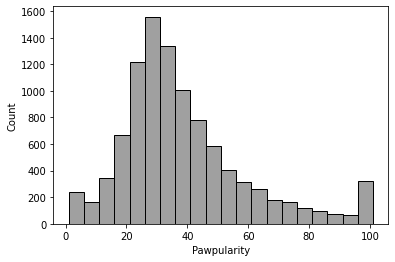

In [ ]:
sns.histplot(data = paw_df, x = 'Pawpularity', binwidth = 5, color = 'gray')
# plt.savefig('paw_score.pdf')

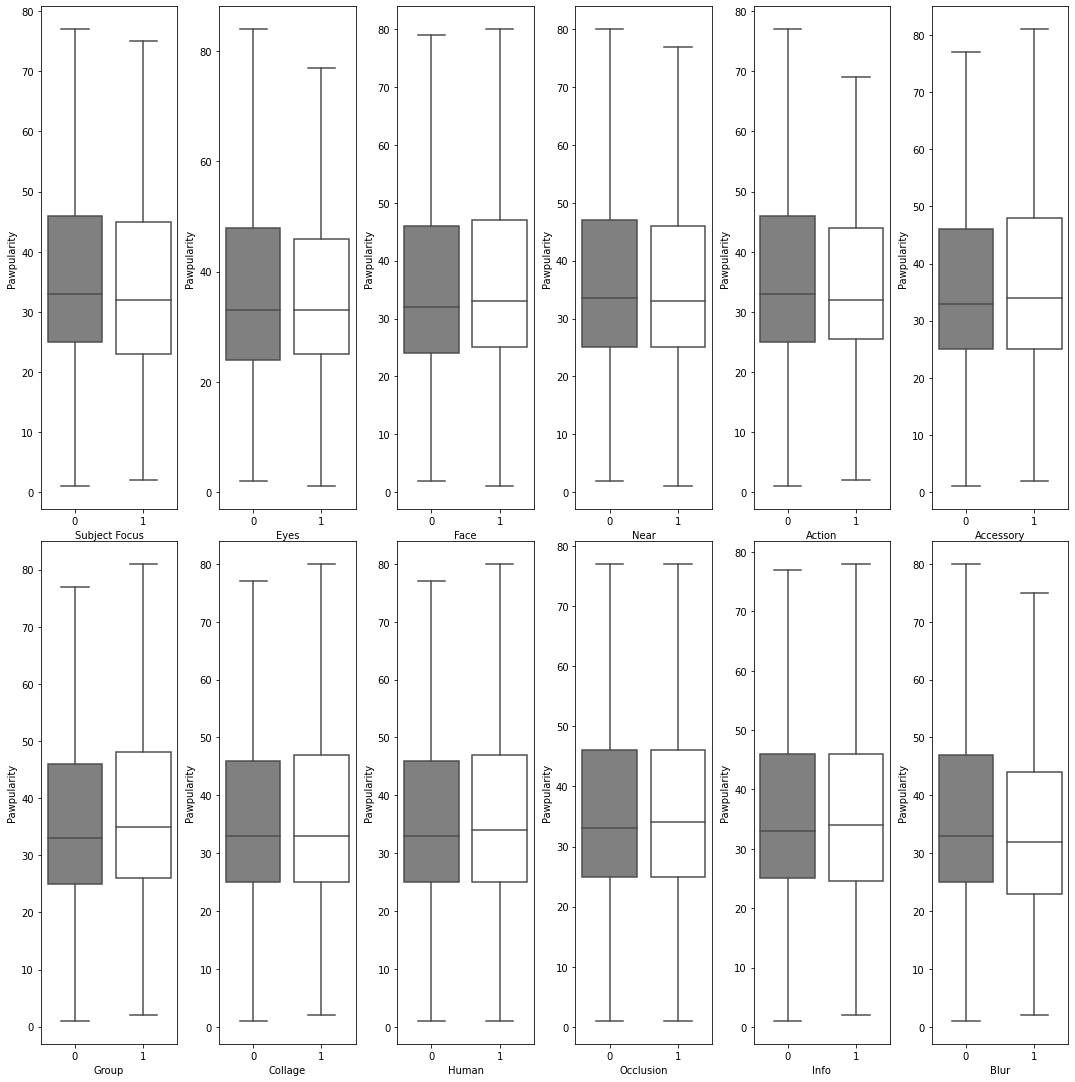

In [ ]:
num_cols = paw_df.shape[1]
fig, axs = plt.subplots(2, 6, figsize = (15, 15))
plt.tight_layout()
for idx, col in enumerate(paw_df.columns):
    if col == 'Pawpularity': continue
    sns.boxplot(ax = axs[idx // 6, idx % 6], x = col, y = 'Pawpularity', data = paw_df, palette = ['gray', 'white'], showfliers  = False)

# plt.savefig('paw_features.pdf')

## Photo Data Analysis


In [ ]:
img_dim_df = pd.read_csv('data/train_dim.csv', index_col = 0)
img_dim_df.head()

,width,height
Id,,
0007de18844b0dbbb5e1f607da0606e0,405,720
0009c66b9439883ba2750fb825e1d7db,1032,774
0013fd999caf9a3efe1352ca1b0d937e,720,960
0018df346ac9c1d8413cfcc888ca8246,405,720
001dc955e10590d3ca4673f034feeef2,540,960


In [ ]:
img_dim_df.value_counts()[:10]

width  height
720    960       3527
1280   960        802
540    960        619
1280   1280       302
960    960        272
405    720        234
1280   720        205
1080   810        133
540    959        122
719    960        107
dtype: int64

Text(0.5, 0, 'pixels')

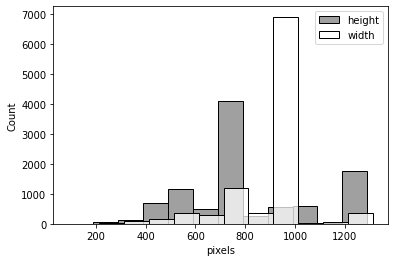

In [ ]:
f, ax = plt.subplots(1, 1)

sns.histplot(ax = ax, data = img_dim_df, x = 'width', binwidth = 100, color = 'gray')
sns.histplot(ax = ax, data = img_dim_df, x = 'height', binwidth = 100, color = 'white')
ax.legend(labels = ['height', 'width'])
plt.xlabel('pixels')
# plt.savefig('paw_dim.pdf')

In [ ]:
img_size_df = pd.Series(img_dim_df['width'] * img_dim_df['height'], name = 'Resolution')
img_size_df = pd.concat([img_size_df, paw_df.Pawpularity], axis = 1)
img_size_df

,Resolution,Pawpularity
Id,,
0007de18844b0dbbb5e1f607da0606e0,291600,63
0009c66b9439883ba2750fb825e1d7db,798768,42
0013fd999caf9a3efe1352ca1b0d937e,691200,28
0018df346ac9c1d8413cfcc888ca8246,291600,15
001dc955e10590d3ca4673f034feeef2,518400,72
...,...,...
ffbfa0383c34dc513c95560d6e1fdb57,754560,15
ffcc8532d76436fc79e50eb2e5238e45,691200,70
ffdf2e8673a1da6fb80342fa3b119a20,623616,20


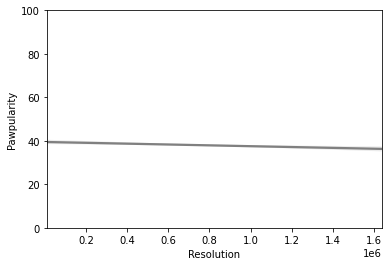

In [ ]:
g = sns.regplot(data = img_size_df, x = 'Resolution', y = 'Pawpularity', scatter = False, color = 'gray')
g.set(xlim = (img_size_df.Resolution.min(), img_size_df.Resolution.max()), ylim = (0, 100))
plt.savefig('paw_size.pdf')

# Data Proprocessing
Before any predictions are made, photos need to be formatted to the correct dimension.


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import random
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torchvision.models.resnet18(pretrained = True)
model.to(device)
model.fc = nn.Linear(512, 1)
model.load_state_dict(torch.load('checkpoints/resnet18_MSE.pt'))

for param in model.parameters():
    param.requires_grad = False

In [ ]:
def preprocess(img, size=256):
    transform = T.Compose([
        T.Resize((640, 480)),
        T.ToTensor(),
    ])
    return transform(Image.open(img))

In [ ]:
X = [Image.open(os.path.join('data', 'train', id + '.jpg')) for id in paw_df.index[:5]]
y = [37.77, 32.83, 35.30, 33.40, 31.40]

Before Preprocessing

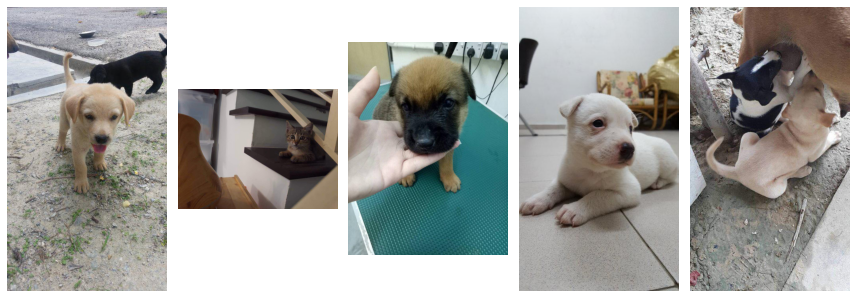

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
plt.gcf().tight_layout()
# plt.savefig('before.pdf')


After Preprocessing

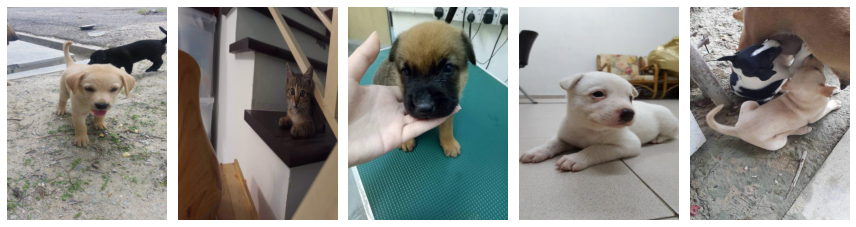

In [ ]:
X = torch.stack([preprocess(os.path.join('data', 'train', id + '.jpg')) for id in paw_df.index[:5]])

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    # plt.title("Prediction:" + str(y[i]) + "\nActual:" + str(paw_df.Pawpularity[i]))
    plt.imshow(X[i].permute(1, 2, 0))
    plt.axis('off')
plt.gcf().tight_layout()
# plt.savefig('predictions.pdf')

# Explainable AI

## Saliency Maps

In [ ]:
# Adapted from Stanford 231n course

def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None

    scores = model(X)
    loss = torch.sqrt((scores - y)**2)
    loss.sum().backward()

    saliency, _ = (X.grad.abs()).max(1)

    return saliency

def show_saliency_maps(X, y, title):
    # Convert X and y from numpy arrays to Torch Tensors
    model.to(device)
    X_tensor = X.to(device)
    y_tensor = y.to(device)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    plt.figure(figsize=(12, 6))
    saliency = saliency.cpu().numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(1, N, i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
    plt.gcf().tight_layout()
    plt.savefig(title)

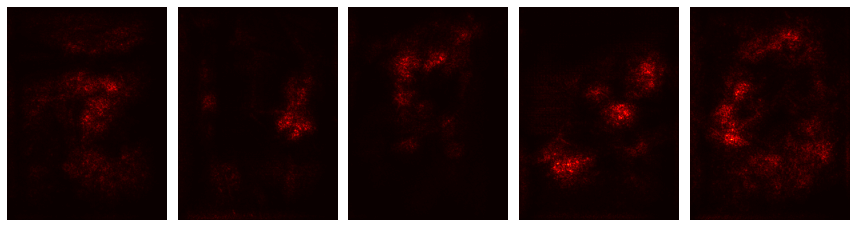

In [ ]:
X = torch.stack([preprocess(os.path.join('data', 'train', id + '.jpg')) for id in paw_df.index[:5]])
y = torch.tensor(paw_df.Pawpularity[:5], dtype = float).reshape(-1, 1)
show_saliency_maps(X, y, 'saliency.pdf')
# plt.savefig('saliency.pdf')

## Gradient Maps

In [ ]:
!pip install grad-cam

In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

# Adapted from grad_cam github
# https://github.com/jacobgil/pytorch-grad-cam
def visualize(X, i):
    X.requires_grad_()   
    target_layers = [model.layer4[-1]]
    input_tensor = X[i].unsqueeze(0)
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    target_category = 0
    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
    grayscale_cam = grayscale_cam[0, :]
    
    rgb_img = X[i].permute(1, 2, 0).detach().numpy()
    # show_cam_on_image
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    return visualization

def show_grad_cams(X, y, title):

    N = X.shape[0]
    plt.figure(figsize=(15, 6))
    for i in range(N):
        plt.subplot(1, N, i + 1)
        plt.imshow(visualize(X, i))
        plt.axis('off')
    plt.gcf().tight_layout()
    plt.savefig(title)

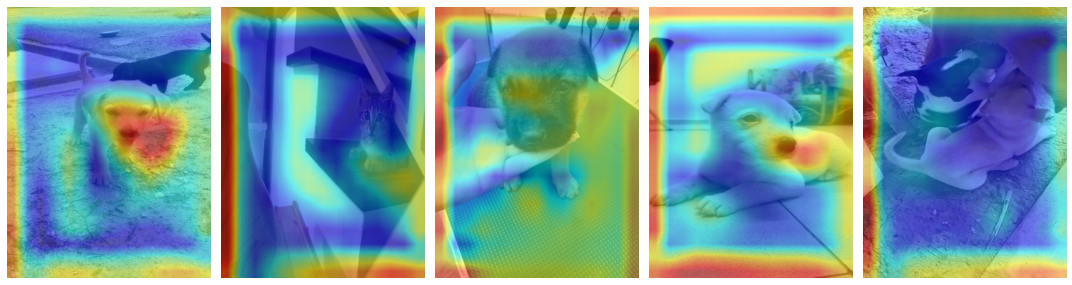

In [ ]:
X = torch.stack([preprocess(os.path.join('data', 'train', id + '.jpg')) for id in paw_df.index[:5]])
y = torch.tensor(paw_df.Pawpularity[:5], dtype = float).reshape(-1, 1)
show_grad_cams(X, y, 'grad_cams.pdf')

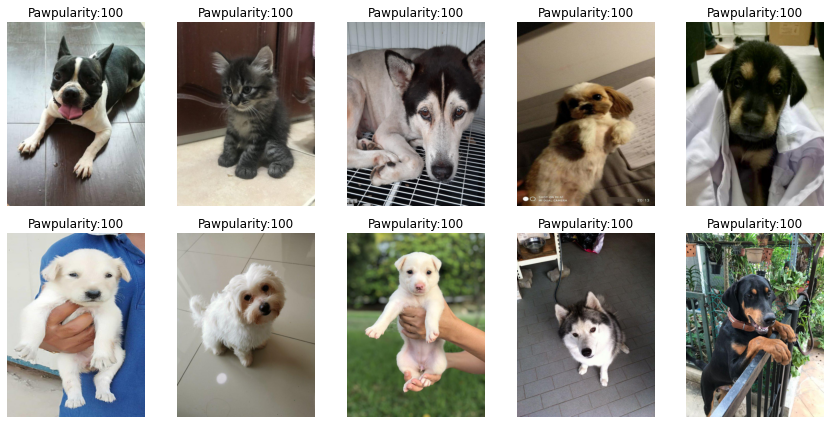

In [ ]:
top5 = paw_df.sort_values(by = 'Pawpularity', ascending = False)
X = [preprocess(os.path.join('data', 'train', id + '.jpg')) for id in top5.index[:10]]
plt.figure(figsize=(12, 6))

N = len(X)
for i in range(N):
    plt.subplot(2, N/2, i + 1)
    plt.title("Pawpularity:" + str(top5.Pawpularity[i]))
    plt.imshow(X[i].permute(1, 2, 0))
    plt.axis('off')
plt.gcf().tight_layout()
# plt.savefig('top.pdf')

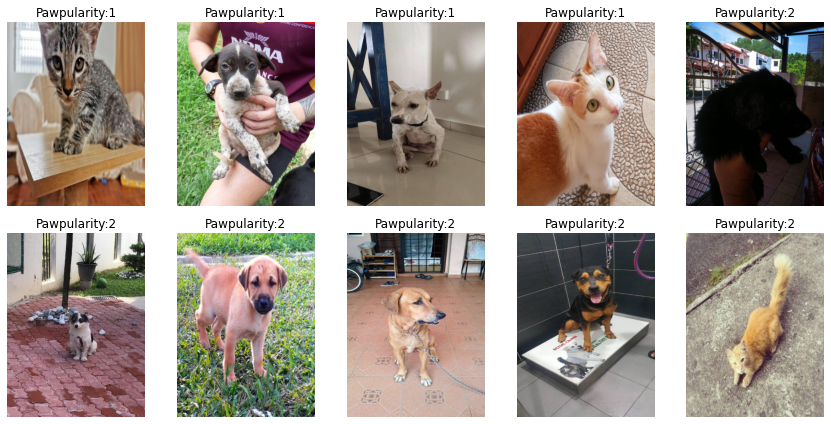

In [ ]:
bottom5 = paw_df.sort_values(by = 'Pawpularity', ascending = True)
X = [preprocess(os.path.join('data', 'train', id + '.jpg')) for id in bottom5.index[:10]]
plt.figure(figsize=(12, 6))
N = len(X)
for i in range(N):
    plt.subplot(2, N/2, i + 1)
    plt.title("Pawpularity:" + str(bottom5.Pawpularity[i]))
    plt.imshow(X[i].permute(1, 2, 0))
    plt.axis('off')
plt.gcf().tight_layout()
# plt.savefig('bottom.pdf')